In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
df =pd.read_csv('data.csv')

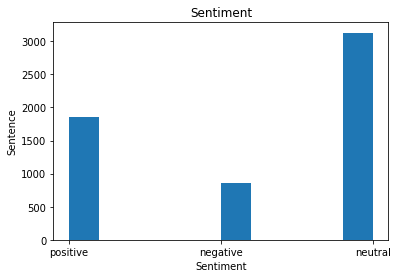

In [9]:
plt.hist(df['Sentiment'], bins=10)
plt.title('Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Sentence')
plt.show()

In [10]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [11]:
def process_data(row):

    text = row['Sentence']
    text = str(text)
    text = ' '.join(text.split())

    encodings = tokenizer(text, padding="max_length", truncation=True, max_length=128)

    label = 0
    if row['Sentiment'] == 'positive':
        label += 1

    encodings['label'] = label
    encodings['text'] = text

    return encodings

In [12]:
process_data({
    'Sentence': 'this is a sample Sentence of a finance.',
    'Sentiment': 'positive'
})

{'input_ids': [101, 2023, 2003, 1037, 7099, 6251, 1997, 1037, 5446, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [13]:
processed_data = []

for i in range(len(df[:1000])):
    processed_data.append(process_data(df.iloc[i]))

In [14]:
from sklearn.model_selection import train_test_split

new_df = pd.DataFrame(processed_data)

train_df, valid_df = train_test_split(
    new_df,
    test_size=0.2,
    random_state=2022
)

In [15]:
import pyarrow as pa
from datasets import Dataset

train_hg = Dataset(pa.Table.from_pandas(train_df))
valid_hg = Dataset(pa.Table.from_pandas(valid_df))

In [16]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [17]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="./result", evaluation_strategy="epoch")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_hg,
    eval_dataset=valid_hg,
    tokenizer=tokenizer
)

In [18]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, __index_level_0__.
***** Running training *****
  Num examples = 800
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 300


Epoch,Training Loss,Validation Loss


In [19]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 200
  Batch size = 8


ValueError: ValueError: Unable to create tensor, you should probably activate truncation and/or padding with 'padding=True' 'truncation=True' to have batched tensors with the same length.

In [21]:
model.save_pretrained('./model/')

Configuration saved in ./model/config.json
Model weights saved in ./model/pytorch_model.bin


In [30]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

new_model = AutoModelForSequenceClassification.from_pretrained('./model/').to(device)

loading configuration file ./model/config.json
Model config BertConfig {
  "_name_or_path": "./model/",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.14.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file ./model/pytorch_model.bin
All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the model checkpoint at ./model/.
If your task is si

In [4]:
from transformers import AutoTokenizer

new_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [5]:
import torch
import numpy as np

def get_prediction(text):
    encoding = new_tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
    encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

    outputs = new_model(**encoding)

    logits = outputs.logits
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    sigmoid = torch.nn.Sigmoid()
    print(sigmoid)
    probs = sigmoid(logits.squeeze().cpu())
    probs = probs.detach().numpy()
    label = np.argmax(probs, axis=-1)
    
    if label == 1:
        return {
            'Sentiment': 'Positive',
            'probability': probs[1]
        }
    else:
        return {
            'Sentiment': 'Negative',
            'probability': probs[-1]
        }

In [6]:
get_prediction('')

NameError: NameError: name 'trainer' is not defined